#Problème 1:





Dans ce problème, il s'agit de reconstruire un champ spatialisé cible à partir d'un prédicteur spatialisé et d'observations ponctuelles.  
Dans la première partie, on adapte simplement la procédure de régression pixel à pixel standard au cas où les données cibles ne sont renseignées qu'en quelques pixels (observations "ponctuelles").\
Dans la seconde partie, on entraîne un réseau à prendre les deux types de données, champ spatialisé et observations ponctuelles, en entrée pour reconstruire au mieux la cible complète.

**NB**: Il vaut mieux traiter les deux parties dans l'ordre.

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
! wget https://www.grosfichiers.com/mfh8gy5ZmfB_zaQP9HZKdDk
! mv mfh8gy5ZmfB_zaQP9HZKdDk utile_BE.py

from utile_BE import *

--2024-01-12 15:20:37--  https://www.grosfichiers.com/mfh8gy5ZmfB_zaQP9HZKdDk
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21240 (21K) [application/octet-stream]
Saving to: ‘mfh8gy5ZmfB_zaQP9HZKdDk’

mfh8gy5ZmfB_zaQP9HZ 100%[===================>]  20.74K  --.-KB/s    in 0s      

2024-01-12 15:20:38 (227 MB/s) - ‘mfh8gy5ZmfB_zaQP9HZKdDk’ saved [21240/21240]



## Partie I : régression sur une cible incomplète

La fonction *gen1* permet d'échantillonner des données d'apprentissage.\
Le paramètre *p* représente la proportion de pixels au niveau desquels les observations ponctuelles sont disponibles. Ces observations ponctuelles, contenues dans le deuxième tenseur fourni par *gen1*, sont positives ou nulles. Les pixels où elles manquent sont associés à la valeur -1.\
Le troisième tenseur correspond à la cible complète (cas idéal où *p*=1). C'est elle qu'on cherche à prédire.

**NB**:
- le deuxième tenseur est une version incomplète du troisième tenseur.
- *gen1* peut être considéré comme un échantillonneur parfait des données d'apprentissage. Il ne produit jamais deux fois les mêmes images.

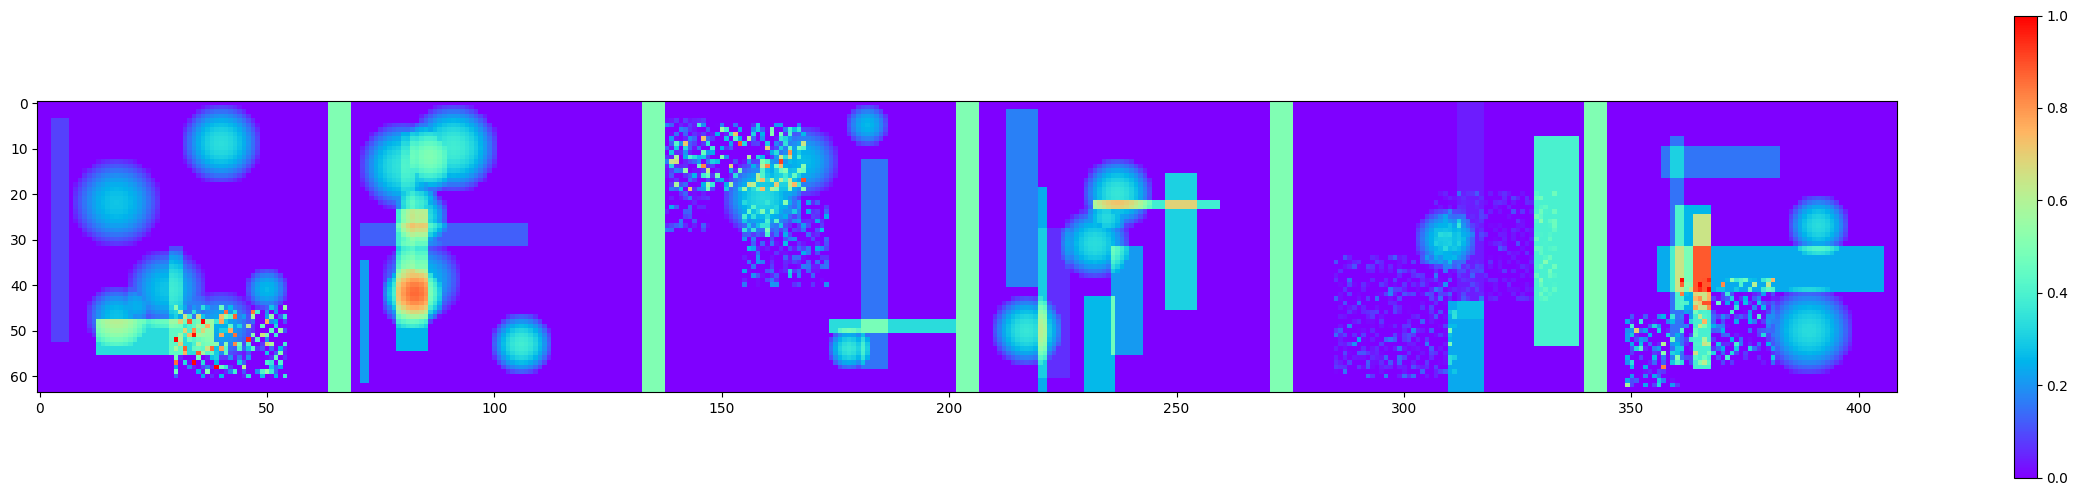

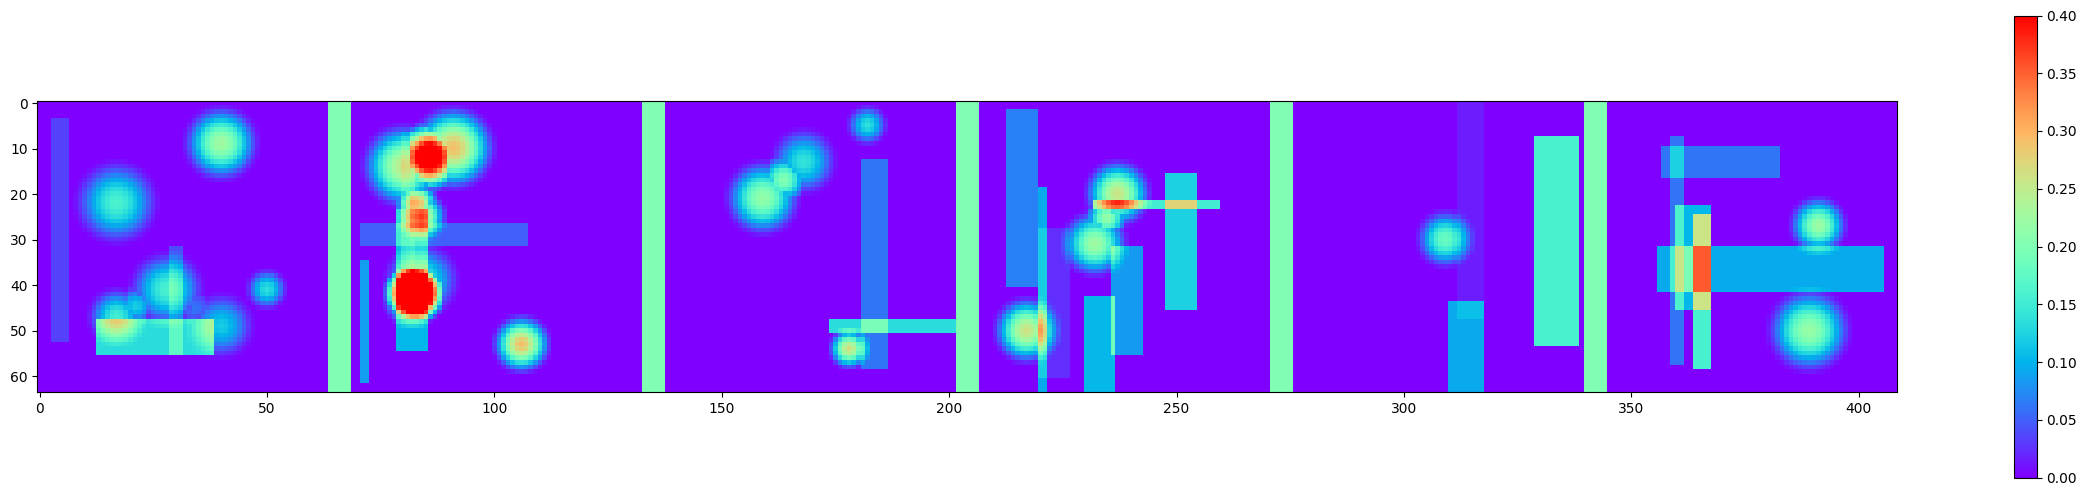

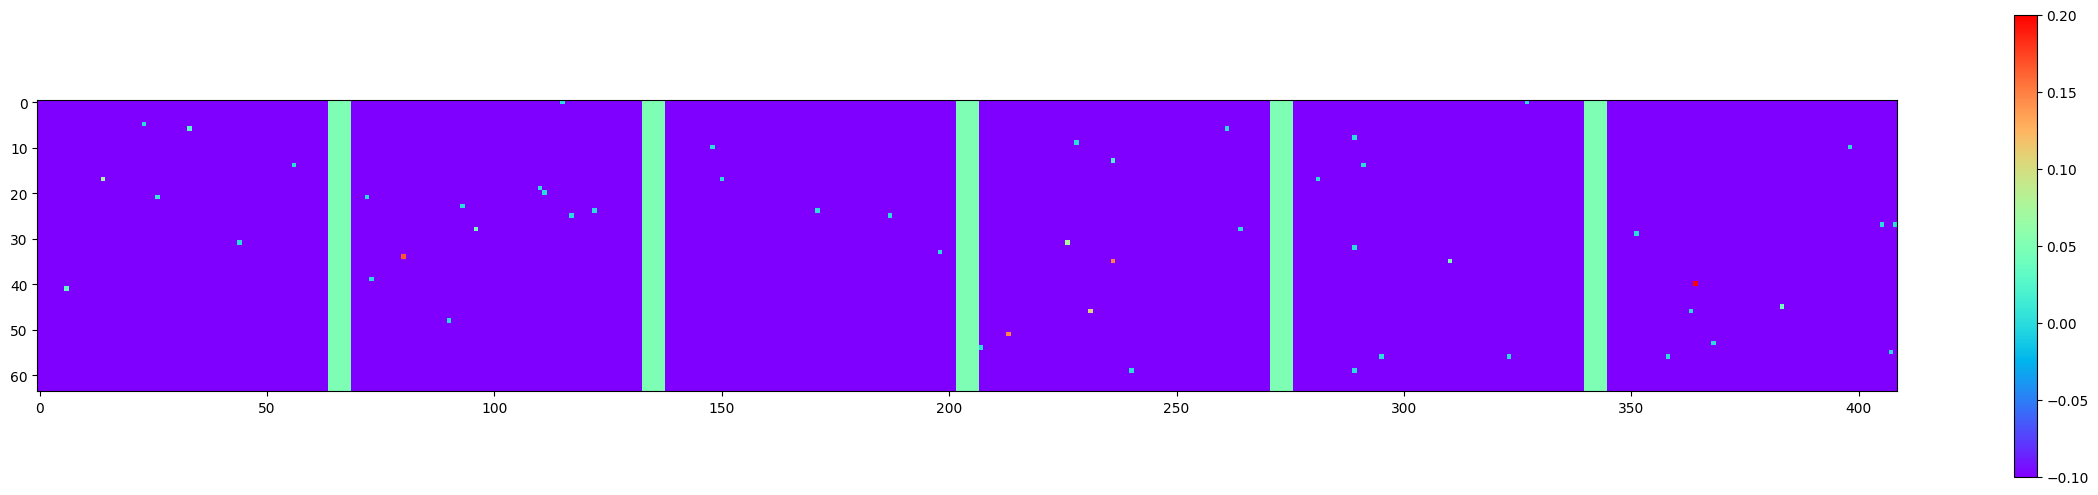

In [3]:
input,  target, fulltarget  = gen1(6,p=0.002)

# input: prédicteur spatialisé
fig0 = plt.figure(0, figsize=(30, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0, max_scale=1)

# fulltarget: cible complète, qu'on ne peut pas utiliser pour l'apprentissage
fig1 = plt.figure(1, figsize=(30, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0, max_scale=0.4)

# target: cible incomplète
fig2 = plt.figure(2, figsize=(30, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1, max_scale=0.2)

**Q1** Pour entraîner un réseau de neurones sur des cibles incomplètes, on définit la fonction de coût *masked_MAE*.
Préciser le rôle du tenseur *mask*. Tester le bon fonctionnement de *masked_MAE* à l'aide d'un batch généré par *gen1*.

---


       


Pour entrainer un réseau de neurones , on définit une fonction de cout MAE qui est utilisée pour entraîner un réseau de neurones sur des cibles incomplètes. Le vecteur `mask` est un tenseur de la même forme que les cibles, contenant des vtaleurs 0 et 1. Une valeur de 1 indique que la cible correspondante est présente et doit être prise en compte dans le calcul de la perte, tandis qu'une valeur de 0 indique que la cible correspondante est manquante et doit être ignorée dans le calcul de la perte.

Cela permet de calculer une erreur moyenne absolue (MAE) sur les seules cibles présentes, en ignorant les cibles manquantes. Ce qui est utile dans notre cas vu qu'on a des données manquantes.

In [4]:
def masked_MAE(output, target, mask):
  return (torch.abs(output-target))[mask].mean()

In [5]:
input, target, fulltarget = gen1(6, p=0.002)
mask = (target >= 0)

mae_de_test = masked_MAE(input, target, mask)
print("MAE:", mae_de_test)

MAE: tensor(0.0169)


**Q2** Pour cette tâche de régression, nous allons entraîner un UNet. Précisez les différentes couches contenues dans ce UNet, leur rôle et le nombre de poids total qu'il contient.

In [6]:
fcn = UNet(1,1,16).cuda()
# Regardons les différentes couches contenues dans UNEt
for module in fcn.modules():
    print(module.__class__.__name__)

UNet
inconv
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
outconv
Conv2d
outconv
Conv2d


## The different layers of a UNet network are:
- Convolutional layers: Characterized by kernels containing weights (one neuron = one kernel). In this version of UNet, each kernel, applied to the input image, provides a feature map with equal spatial dimensions (which is not the case in a ResNet due to the stride parameter > 1).
- Maxpooling: These layers reduce the size of the intermediate image by taking the maximum values over 2x2 squares, channel by channel.
- Transposed convolution layers with stride = 2: They generate feature maps with spatial dimensions twice those of the input image.
- Non-linear activation functions ReLU (positive part).
- BatchNorm2d layers, often used to normalize activations and stabilize training.

##The total number of weights :

In [7]:
nb_weights = 0
for module in fcn.modules():
  # On compte les poids des différentes couches
  #Pour les couchs de convolutions
  #Pour les couches de convolution transposées avec stride 2
  #Pour les couches de normalization de lot bidimensionnelle
  if isinstance(module, nn.Conv2d)\
    or isinstance(module, nn.BatchNorm2d)\
    or isinstance(module, nn.ConvTranspose2d):
    print(module.__class__.__name__)
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print("nb de poids : " + str(nb_weights))

# Il y a 926786 poids en total

Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
Conv2d
nb de poids : 926786


**Q3** Dans la fonction *run_train* coder une époque de l'entraînement du UNet en exploitant la cible incomplète. Rester sur CPU. **Commenter votre code**. \
On utilisera les hyperparamètres suivants :

In [8]:
# optim: Adam, lr = 0.001
# batch par époque: 50
# taille d'un batch: 64
# p = 0.002

torch.manual_seed(0)
optimizer = optim.Adam(fcn.parameters(), 0.001)

In [9]:

nepochs = 50
nbatches = 100
batchsize = 64
p = 0.002

train_losses_is = []

def run_train(fcn, optimizer, p = 0.002):

  for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        input,  target, fulltarget  = gen1(6,p)

        input = input.cuda()
        target = fulltarget.cuda()


        optimizer.zero_grad()
        output = fcn(input)

        loss = masked_MAE(output, target, mask)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_is.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

  return fcn, optimizer



In [10]:
fcn, optimize = run_train(fcn, optimizer, p)

Epoch 0
epoch loss : 

0.064613774
Epoch 1
epoch loss : 

0.021268137
Epoch 2
epoch loss : 

0.016336085
Epoch 3
epoch loss : 

0.016786627
Epoch 4
epoch loss : 

0.015819635
Epoch 5
epoch loss : 

0.014864247
Epoch 6
epoch loss : 

0.015592393
Epoch 7
epoch loss : 

0.013564033
Epoch 8
epoch loss : 

0.012352242
Epoch 9
epoch loss : 

0.013216133
Epoch 10
epoch loss : 

0.013166399
Epoch 11
epoch loss : 

0.0118316505
Epoch 12
epoch loss : 

0.011084494
Epoch 13
epoch loss : 

0.011283254
Epoch 14
epoch loss : 

0.011806688
Epoch 15
epoch loss : 

0.011806085
Epoch 16
epoch loss : 

0.010661121
Epoch 17
epoch loss : 

0.011585624
Epoch 18
epoch loss : 

0.010247434
Epoch 19
epoch loss : 

0.011330699
Epoch 20
epoch loss : 

0.009776884
Epoch 21
epoch loss : 

0.0103119705
Epoch 22
epoch loss : 

0.009576889
Epoch 23
epoch loss : 

0.0102416435
Epoch 24
epoch loss : 

0.0101905
Epoch 25
epoch loss : 

0.0101403035
Epoch 26
epoch loss : 

0.009429133
Epoch 27
epoch loss : 

0.01000556
E

In [11]:
import time
t = time.time()
run_train(fcn, optimizer, p = 0.002)
print(time.time() - t)

Epoch 0
epoch loss : 

0.0076951836
Epoch 1


KeyboardInterrupt: 

**Q4** Dans la fonction *run_train_gpu*, passer la phase d'entraînement sur GPU. Evaluer le speed-up.

In [12]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [13]:

train_losses_is_gpu = []

def run_train_gpu(fcn, optimizer, p = 0.002):

  for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs

        input,  target, fulltarget  = gen1(6,p)

        # Moving data to the GPU
        input = input.to(device)
        target = target.to(device)
        fulltarget = fulltarget.to(device)

        optimizer.zero_grad()
        output = fcn(input)

        loss = masked_MAE(output, target, mask)
        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_is_gpu.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

  return fcn, optimizer


In [14]:
fcn, optimizer = run_train_gpu(fcn, optimizer, p = 0.002)

Epoch 0
epoch loss : 

0.49818015
Epoch 1
epoch loss : 

0.042872347
Epoch 2
epoch loss : 

0.032246243
Epoch 3
epoch loss : 

0.029853651
Epoch 4


KeyboardInterrupt: 

In [75]:
# pour le calcul du speed-up
import time
t = time.time()
run_train_gpu(fcn, optimizer, p = 0.002)
print(time.time() - t)

Epoch 0
epoch loss : 

0.008922745
Epoch 1
epoch loss : 

0.008555699
Epoch 2
epoch loss : 

0.0074388534
Epoch 3
epoch loss : 

0.00851435
Epoch 4
epoch loss : 

0.007212342
Epoch 5
epoch loss : 

0.009583595
Epoch 6
epoch loss : 

0.00920914
Epoch 7
epoch loss : 

0.007633725
Epoch 8
epoch loss : 

0.009269156
Epoch 9
epoch loss : 

0.007125284
Epoch 10
epoch loss : 

0.008081138
Epoch 11
epoch loss : 

0.0070984317
Epoch 12
epoch loss : 

0.00679064
Epoch 13
epoch loss : 

0.0069415825
Epoch 14
epoch loss : 

0.0069220783
Epoch 15
epoch loss : 

0.0068819146
Epoch 16
epoch loss : 

0.007239048
Epoch 17
epoch loss : 

0.006653098
Epoch 18
epoch loss : 

0.007502916
Epoch 19
epoch loss : 

0.007667701
Epoch 20
epoch loss : 

0.008904737
Epoch 21
epoch loss : 

0.0082232775
Epoch 22
epoch loss : 

0.007853935
Epoch 23
epoch loss : 

0.010907862
Epoch 24
epoch loss : 

0.0072818245
Epoch 25
epoch loss : 

0.008262605
Epoch 26
epoch loss : 

0.0077134003
Epoch 27
epoch loss : 

0.0082931

Dans les questions suivantes, nous allons chercher à évaluer l'effet de la densité des observations ponctuelles *p* sur les performances en généralisation au cours de l'entraînement.

**Q5**  Pour comparer les performances en généralisation au cours de l'entraînement, on se permet d'utilise la MAE entre outputs et cibles **complètes**. En général, peut-on se permettre d'utiliser les mêmes données que celles qui ont été utilisées pendant la phase d'entraînement ? Est-ce le cas ici ? \
Dans la fonction *run_trainval_gpu()* suivante, évaluer les performances en généralisation au cours de l'entraînement (variable *epoch_MAE_validation*).
Eviter tout calcul superflux.

In general, it's not a good idea to use the same data for training and validation. That is becauses of the fact that it could lead to over-fitting. In other words, the whole point of generalization is evaluating the model's capacity to classify images or data that it has never seen before. If we use the same data as the training, then we cannot judge objectivelly and efficiently the model's capacity to correctly classify in the case of a completely new situation.

In [17]:
train_losses_is_gpu = []
epoch_Mae_validation = []

def run_trainval_gpu(fcn, optimizer, p = 0.002):
  train_losses_is_gpu = []
  epoch_Mae_validation = []
  for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    epoch_MAE_validation = []  # Initialize the list for storing MAE values
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs

        input,  target, fulltarget  = gen1(6,p)

        # Moving data to the GPU
        input = input.to(device)
        target = target.to(device)
        fulltarget = fulltarget.to(device)

        optimizer.zero_grad()
        output = fcn(input)

        loss = masked_MAE(output, target, mask)
        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_is_gpu.append(epoch_loss)
    epoch_MAE_validation.append(masked_MAE(output, fulltarget, mask).detach().cpu())  # Calculate and store MAE

    print('epoch loss : \n')
    print(epoch_loss)

  return fcn, optimizer, epoch_MAE_validation, train_losses_is_gpu



In [15]:
fcn, optimizer, MAE_validation, train_losses_is_gpu = run_trainval_gpu(fcn, optimizer, p = 0.002)

Epoch 0
epoch loss : 

0.279611
Epoch 1
epoch loss : 

0.04077068
Epoch 2
epoch loss : 

0.028088732
Epoch 3


KeyboardInterrupt: 

\**Q6** Générer deux versions du UNet précédent comportant les **mêmes poids initiaux**. Entraîner ces versions sur cinquante époques, chacun pour une valeur de *p* différente : *p* = 0.01 et *p* = 0.002.
**Commenter votre code**. Tracer et discuter les courbes d'apprentissage.

In [ ]:
nepochs = 50
scores_1 = []
scores_2 = []
MAE_validation_1 = []
MAE_validation_2 = []

# Training with p = 0.01
p = 0.01
fcn, optimizer, MAE_validation, train_losses_is_gpu1 = run_trainval_gpu(fcn.to(device), optimizer, p)
scores_1 = train_losses_is_gpu1
MAE_validation_1 = MAE_validation

# Training with p = 0.002
p = 0.002
fcn, optimizer, MAE_validation2, train_losses_is_gpu2 = run_trainval_gpu(fcn.to(device), optimizer, p)
scores_2 = train_losses_is_gpu2
MAE_validation_2 = MAE_validation2




Epoch 0
epoch loss : 

0.010774158
Epoch 1
epoch loss : 

0.011250789
Epoch 2
epoch loss : 

0.0085716555
Epoch 3
epoch loss : 

0.011751827
Epoch 4
epoch loss : 

0.013857096
Epoch 5
epoch loss : 

0.013888695
Epoch 6
epoch loss : 

0.010657443
Epoch 7
epoch loss : 

0.010917566
Epoch 8
epoch loss : 

0.012198656
Epoch 9
epoch loss : 

0.0105858315
Epoch 10
epoch loss : 

0.011273738
Epoch 11
epoch loss : 

0.0127779795
Epoch 12
epoch loss : 

0.013145042
Epoch 13
epoch loss : 

0.0125548635
Epoch 14
epoch loss : 

0.010120626
Epoch 15
epoch loss : 

0.009061004
Epoch 16
epoch loss : 

0.010787779
Epoch 17
epoch loss : 

0.013937278
Epoch 18
epoch loss : 

0.011599812
Epoch 19
epoch loss : 

0.0106094275
Epoch 20
epoch loss : 

0.011984411
Epoch 21
epoch loss : 

0.012033369
Epoch 22
epoch loss : 

0.011670194
Epoch 23
epoch loss : 

0.011169058
Epoch 24
epoch loss : 

0.0107566165
Epoch 25
epoch loss : 

0.010758326
Epoch 26
epoch loss : 

0.009849221
Epoch 27
epoch loss : 

0.010783

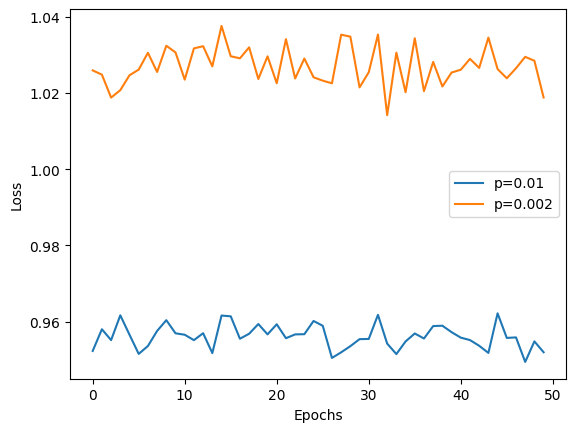

In [90]:
# Plotting the learning curves
plt.plot(range(nepochs), scores_1, label='p=0.01')
plt.plot(range(nepochs), scores_2, label='p=0.002')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

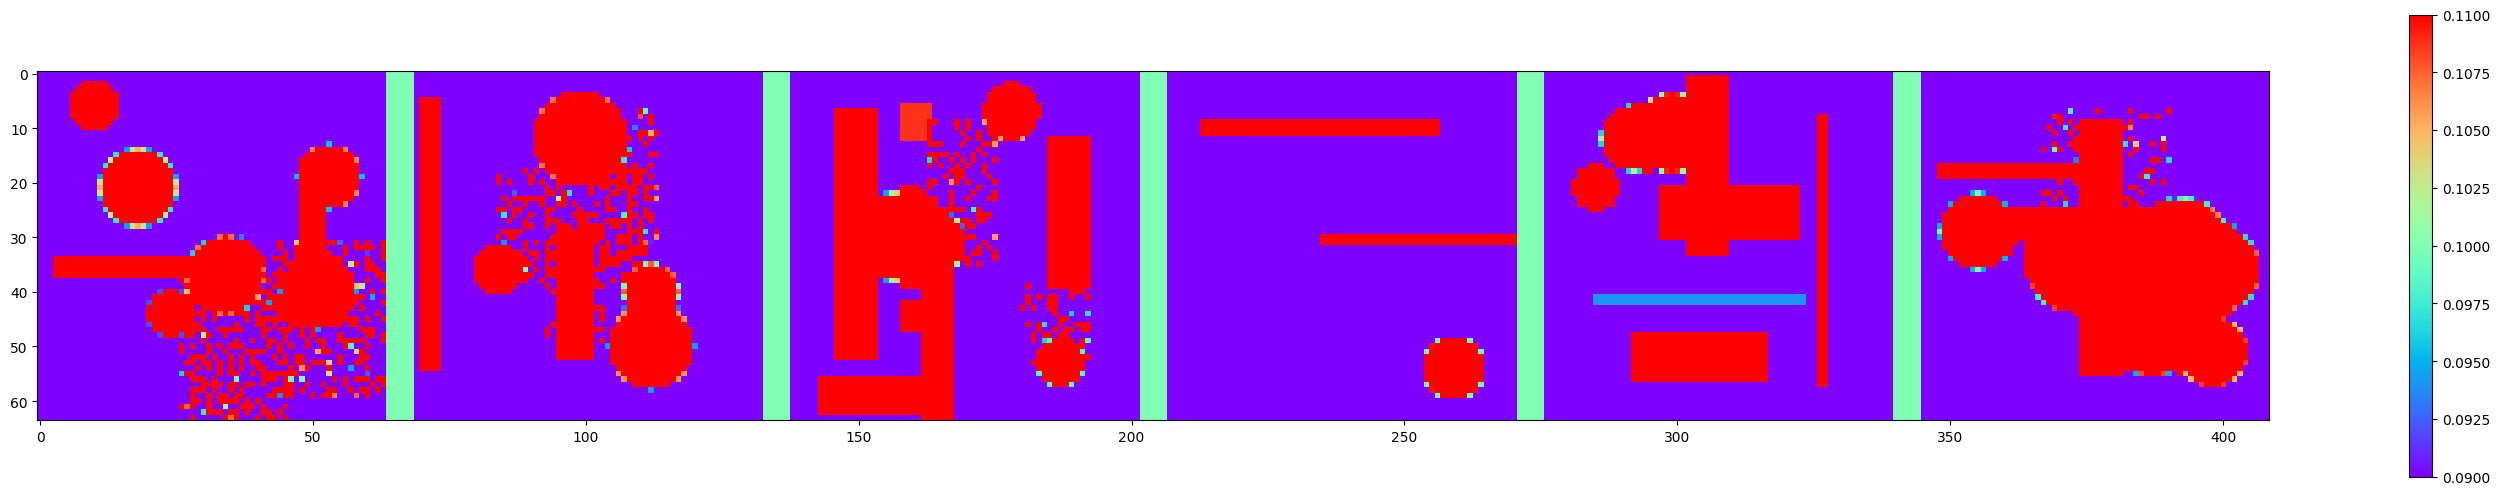

NameError: name 'full_target' is not defined

<Figure size 3600x600 with 0 Axes>

In [91]:
fig = plt.figure(0, figsize=(36, 6))  # première ligne: entrées
voir_batch2D(input.cpu(), 6, fig, k=0, min_scale=0.09, max_scale=0.11)

fig2 = plt.figure(1, figsize=(36, 6))  # seconde ligne: vérité terrain
voir_batch2D(fulltarget + (input.cpu()) * 10, 6, fig2, k=0, min_scale=0, max_scale=1)

fig3 = plt.figure(2, figsize=(36, 6))  # dernière ligne: sorties
voir_batch2D(output.detach().cpu() + (input.cpu()) * 10, 6, fig2, k=0, min_scale=0, max_scale=1.)


**Q7** Combien faut-il d'époques supplémentaires au deuxième *fcn* pour rattraper le premier ?

On peut voire que pour p = ... , le training n'est pas encore achevé au bout de 50 Epochs. Mais en augmentant le nombre à ..., il rattrape le premier.

## **Partie II** : cas où les observations ponctuelles peuvent aussi servir d'entrées.

Dans cette partie, nous supposons que les observations ponctuelles sont disponibles non seulement pendant l'apprentissage, mais aussi en phase d'inférence.
Il devient donc possible de l'utiliser comme une entrée.

Avec la fonction *gen2*, cela va même s'avérer nécessaire : les observations ponctuelles contiennent une information essentielle à la prédiction de la cible complète.

En effet, le premier tenseur founi par *gen2* (ligne 1 ci-dessous) permet de dire où sont les pixels associés à des valeurs non nulles dans la cible complète (ligne 2).
Par contre, ce premier tenseur ne suffit pas à préciser l'intensité du signal cible : pour certaines cellules (premier type de cellules, en rouge sur la troisième ligne) le signal cible est plus fort que sur le premier tenseur, alors que pour d'autres cellules (deuxième type de cellule, en cyan), il est plus faible. Et rien dans le premier tenseur n'indique à quel type de cellule on a affaire.

In [ ]:
input, target, fulltarget  = gen2(6,0.01)

# ligne 1: le prédicteur spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ligne 2: le signal cible complet où les deux types de cellules apparaissent
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0,max_scale=1)

# ligne 3: le rapport entre les deux
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((fulltarget/input), 6, fig1, k=0, min_scale=0,max_scale=1)

In [ ]:
# les observations ponctuelles:
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1,max_scale=0.2)

Comme dans la partie I, les observations ponctuelles sont les seules parties de la cible disponibles au cours de l'entraînement. Mais, comme expliqué au-dessus, ces observations ponctuelles seront aussi disponibles en phase d'inférence. Comme elles contiennent une information essentielle, il va donc s'agir d'entraîner le réseau à les exploiter à la fois comme cibles et comme entrées.


**NB:** De même que dans la partie I, dans le deuxième tenseur les valeurs manquantes sont codées par -1 et toutes les autres valeurs sont positives ou nulles.

**Q1** Dans un premier temps, entraîner un UNet **en n'utilisant que le premier tenseur ("input") en entrée**. Toutes les observations ponctuelles disponibles peuvent être utilisées dans la cible.
Les autres con\signes sont :
- Choisir la fonction de coût de manière à estimer la **moyenne conditionnelle à l'entrée**.
- Pour la phase de validation, évaluer l'écart entre la cible complète et les outputs de la phase d'entraînement (comme dans la partie I).
- Utiliser les hyperparamètres ci-dessous:

In [ ]:
import torch.optim as optim
fcn = UNet(1,1,16)
nepochs = 15
nbatches = 100
batchsize = 64
p = 0.01

In [ ]:
def conditional_MAE(output, target, input):
    return torch.abs(output - target).mean(dim=(1, 2)) / input.mean(dim=(1, 2))

In [ ]:
criterion = nn.MSELoss()

In [ ]:
scores_1 = []

def run_train_gpu_only_input(fcn, optimizer, p=0.002):
  train_losses_is_gpu = []
  epoch_Mae_validation = []
  for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses = []
    epoch_MAE_validation = []  # Initialize the list for storing MAE values
    for i in range(nbatches):  # nbatch = datasetsize/batchsize
      # Load inputs

      input, target, fulltarget = gen2(6, p)

      # Moving data to the GPU
      input = input.to(device)
      target = target.to(device)
      fulltarget = fulltarget.to(device)

      optimizer.zero_grad()
      output = fcn(input)

      loss = criterion(output, fulltarget)
      loss.backward()

      optimizer.step()

      epoch_losses.append(loss.detach().cpu())

      del target, input, loss
      torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_is_gpu.append(epoch_loss)
    epoch_MAE_validation.append(masked_MAE(output, fulltarget, mask).detach().cpu())  # Calculate and store MAE

    print('epoch loss : \n')
    print(epoch_loss)

  return fcn, optimizer, epoch_MAE_validation, train_losses_is_gpu



**Q2** Pourquoi les performances stagnent-elles ? Visualiser quelques outputs et vérifier que le réseau restitue simplement le champ d'entrée. Expliquer pourquoi, intuitivement.

In [ ]:
fcn.eval()
input, target, fulltarget = gen2(6, p)

output = fcn(input.to(device))
output = output.detach().cpu()

# Visualize a few outputs
for i in range(3):
    plt.figure(figsize=(6, 6))
    plt.imshow(output[i, 0], cmap='gray')
    plt.title('Output {}'.format(i+1))
    plt.axis('off')
    plt.show()


Intuitivement, si le réseau restitue simplement le champ d'entrée, cela pourrait signifier que le réseau n'a pas réussi à apprendre les caractéristiques pertinentes des données pour prédire correctement la cible. Cela pourrait être dû à un manque de capacité du réseau (par exemple, pas assez de couches ou de neurones), à un mauvais choix de fonction de coût, ou à un problème avec les données elles-mêmes (par exemple, elles sont trop bruitées ou pas assez variées).

On cherche maintenant à utiliser une partie des observations ponctuelles comme prédicteurs.\
Une idée simple consiste à définir un deuxième tenseur d'entrée ne comptant (environ) qu'une observation ponctuelle sur deux. Les autres observations ponctuelles sont quant elles utilisées comme cible.

**Q3** Mettre en oeuvre cette idée.

**Remarques:**
- La fonction *torch.bernoulli* permet de masquer environ 50% des valeurs d'un tenseur...
- Attention à la mutabilité des tenseurs pytorch.

In [ ]:
# Generate the input, target, and fulltarget tensors
input, target, fulltarget = gen2(6, p)

# Create a mask tensor to randomly select half of the punctual observations
mask = torch.bernoulli(torch.full_like(input, 0.5))

# Apply the mask to create the second input tensor
input2 = input * mask

# Use the remaining punctual observations as the target
target2 = target * (1 - mask)

# Print the shapes of the tensors for verification
print("Input shape:", input.shape)
print("Input2 shape:", input2.shape)
print("Target shape:", target.shape)
print("Target2 shape:", target2.shape)



**Q4** Procéder à un apprentissage sur dix époques, comparer la courbe d'apprentissage obtenue avec la précédente et expliquer.

In [ ]:
nepochs = 15
fcn = UNet(2,1,16).cuda()

...

In [ ]:
scores_2  = []

...

**Q5** Visualiser des batches d'outputs. Dans quelle mesure le réseau parvient-il à lever l'ambiguïté sur le type de cellule en présence ?

In [ ]:
fcn.eval()
input,  target, fulltarget  = gen2(6, p = 0.005)

# prédicteur spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# obs ponctuelles et cible complète
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((target>=0) + fulltarget, 6, fig1, k=0, min_scale=0.,max_scale=1)

output = ...

...

**Q6** Au cours d'un apprentissage, nous avons utilisé (environ) la moitié des observations ponctuelles à disposition. Quel peut être le défaut de cette approche ? Jouer sur la valeur de *p* pour illustrer votre propos.

**Q7** Pour prédire la valeur d'un pixel, un FCN permet de prendre en compte le contexte, c'est à dire l'information contenue dans un large voisinage autour du pixel d'intérêt.\
Cette qualité était-elle nécessaire pour traiter la **partie I** du problème ? Etait-elle nécessaire pour traiter la **partie II** ? Justifier dans les deux cas.